# Tutorial: Global optimization with PyMoosh - A simple example

This tutorial demonstrates optimization of a simple Bragg mirror. Note that the aim is not to reproduce the exact results from the paper, but to demonstrate how to setup the problem.

In [ ]:
# install dependecies
!pip install pymoosh

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 2.7 MB/s eta 0:00:00


## Load modules

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PyMoosh as pm

## Helper: define the optimization geometry

Here we define the geometric model to be optimized and its parametrization. We will optimize the thicknesses of a layer-stack of two alterning dielectric materials.
technically, the geometry is described by an instance of PyMoosh's `structure` class. The optimizer will generate sequences of floats. Therefore, we will write a wrapper that converts a list of thicknesses (provided by the optimizer) into a pymoosh structure object (required for the simulation). Furthermore, we also pass the additional fixed parameters that are not optimized by still needed for the structure description as keyword arguments. Here these are the material refractive indices of the two used dielectrics and of the environment.

In [ ]:
def setup_structure(thick_list, mat_env, mat1, mat2):
    """helper to create pymoosh structure object, alternating 2 materials

    Args:
        thick_list (list): list of thicknesses, top layer first
        mat_env (float): environment ref. index
        mat1 (float): material 1 ref. index
        mat2 (float): material 2 ref. index

    Returns:
        PyMoosh.structure: multi-layer structure object
    """
    thick_list = list(
        thick_list)  # convert to list for convenience when stacking layers
    n = len(thick_list)

    materials = [mat_env**2, mat1**2, mat2**2]  # permittivities!
    # periodic stack. first layer: environment, last layer: substrate
    stack = [0] + [2, 1] * (n//2) + [2]
    thicknesses = [0.] + thick_list + [0.]

    structure = pm.Structure(
        materials, stack, np.array(thicknesses), verbose=False)

    return structure

## Helper: define the optimization target

Now we define the physical property to be optimized - the *cost* function.
By default, optimization algorithms minimize the cost, so we will use $f_{cost} = 1-R$ in order to maximize the reflectivity of a layer stack.

In [ ]:
# ------- the optimization target function -------
def cost_minibragg(x, mat_env, mat1, mat2, eval_wl):
    """ cost function: maximize reflectance of a layer-stack

    Args:
        x (list): thicknesses of all the layers, starting with the upper one.

    Returns:
        float: 1 - Reflectivity at target wavelength
    """
    structure = setup_structure(x, mat_env, mat1, mat2)

    # the actual PyMoosh reflectivity simulation
    _, R = pm.coefficient_I(structure, eval_wl, 0., 0)
    cost = 1 - R

    return cost

## Setting up the optimization

- we define the specific configuration of our optimization problem.
- we write a wrapper to the above cost function because the PyMoosh differential evolution requires a cost function that takes only a single vector $x$.
- then we set up the parametrization by defining vectors of lower and upper bounds containing the exact number of values as used in the optimization (= number of layer thicknesses)
- finally, we run the optimizer ("differential evolution" with a population size of 30).

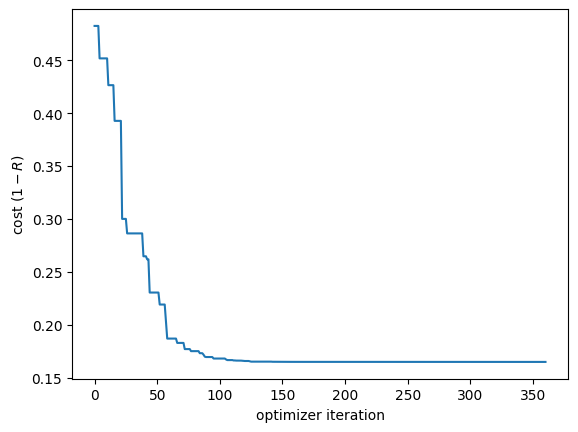

In [ ]:
# ------- define "mini-bragg" optimization problem
nb_layers = 10     # number of layers of full stack
target_wl = 600.0  # nm
mat_env = 1.0      # materials: ref. index
mat1 = 1.4
mat2 = 1.8
min_thick = 0      # no negative thicknesses
max_thick = target_wl / (2 * mat1)  # lambda/2n

# wrapper taking only a single vector x and
# that passes the fixed arguments to the cost function
def cost_wrapper(x): return cost_minibragg(
    x, mat_env=mat_env, mat1=mat1, mat2=mat2, eval_wl=target_wl)


# ------- setup the parametrization
budget = 10000     # stop criterion: allowed number of evaluations
N_population = 30  # population size (DE algo-specific!)

X_min = np.array([min_thick]*nb_layers)
X_max = np.array([max_thick]*nb_layers)


best, convergence = pm.differential_evolution(
    cost_wrapper, budget, X_min, X_max, population=N_population)

plt.figure()
plt.plot(convergence)
plt.xlabel("optimizer iteration")
plt.ylabel("cost ($1 - R$)")
plt.show()

## Analyze the result

Finally, we calculate the spectrum for the final best solution and plot the results:

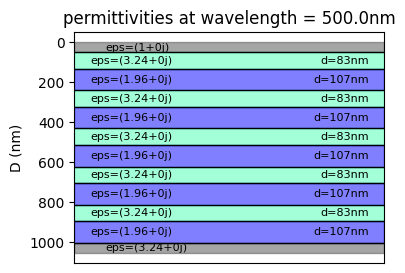

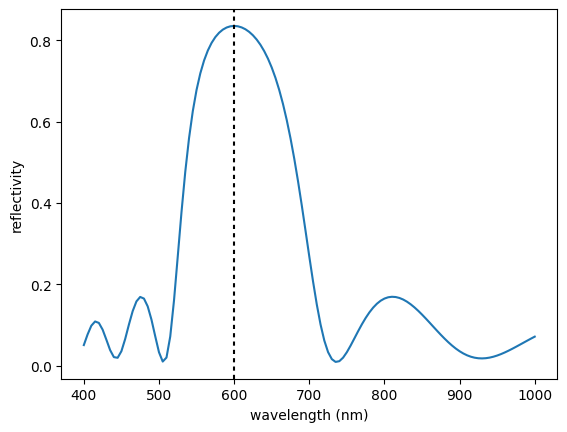

In [ ]:
struct = setup_structure(best, mat_env, mat1, mat2)


# --- calc spectrum
wls = np.linspace(400, 1000, 121)
R = np.zeros_like(wls)
for i, wl in enumerate(wls):
    _, _, R[i], _ = pm.coefficient(struct, wl, incidence=0, polarization=0)


# --- plot
plt.figure(figsize=(4,3))
struct.plot_stack()

plt.figure()
plt.plot(wls, R, label='R')
plt.axvline(target_wl, color='k', dashes=[2, 2])
plt.xlabel('wavelength (nm)')
plt.ylabel('reflectivity')
plt.show()